## О задаче

Построить модель логистической регрессии и модель градиентного бустинга для предсказания оттока клиентов телекоммуниционной компании. Сравнить их по метрике ROC-AUC

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

## Загрузка данных

In [2]:
data = pd.read_csv('~/Downloads/customer_data.csv')

In [3]:
data.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Объекты имеют 20 признаков, признак Churn является целевым. Явных пропусков в данных нет, но заметим, что тип признака TotalSpent не является числовым. 

In [5]:
data['TotalSpent'].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

Видим, что 9 значений в столбце TotalSpent содержат пробел вместо числа. Так как количество пропусков мало, 
удалим строки с пропущенными значениями и преобразуем тип столбца к числовому:

In [6]:
data.drop(data[data['TotalSpent'] == ' '].index, inplace=True)
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])

Разделим признаки на числовые и категориальные:

In [7]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## Разделение данных на обучающую и тестовую выборки

In [8]:
X = data[feature_cols]
y = data[target_col]

In [9]:
X.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


In [10]:
y.head(5)

0    0
1    0
2    1
3    0
4    0
Name: Churn, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Анализ данных

Разобьем обучающую выборку по значению целевого признака, чтобы посмотреть на различия распределений: 

In [12]:
train_1 = X_train[y_train == 1]
train_0 = X_train[y_train == 0]

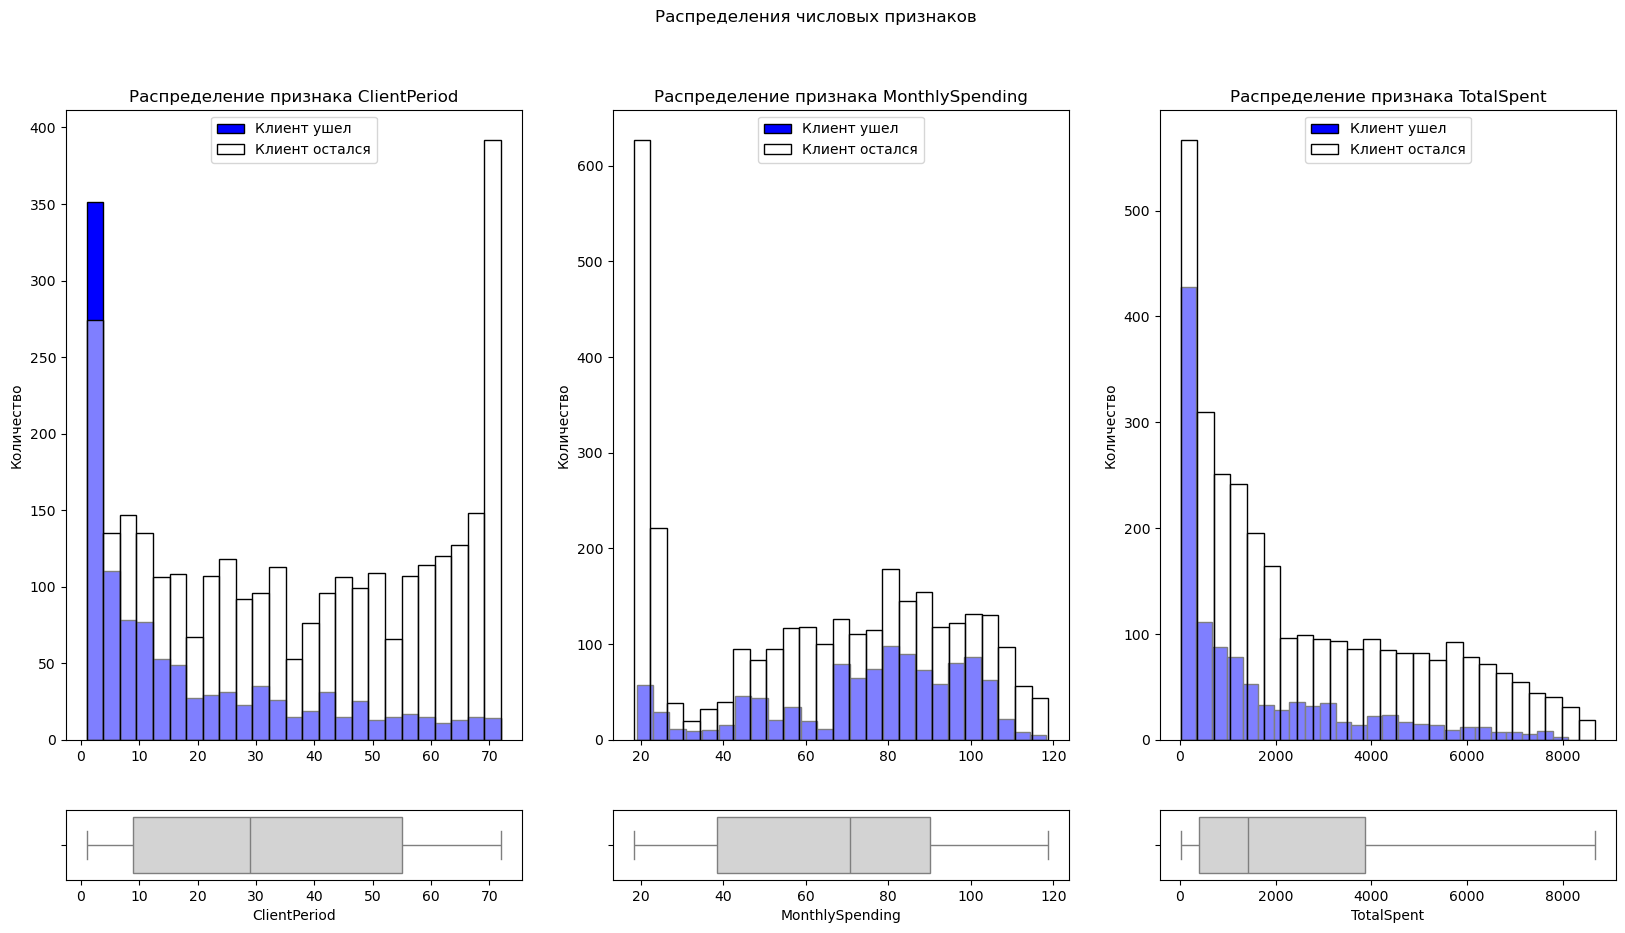

In [13]:
fig,(ax_hist, ax_box) = plt.subplots(nrows=2,
                                     ncols=3, 
                                     figsize=(20,10),
                                     sharex=False,
                                     gridspec_kw={"height_ratios": (0.9, 0.1)})
fig.suptitle('Распределения числовых признаков')

for i, num_col in enumerate(num_cols):
    
  sns.histplot(train_1[num_col],
               bins=25,
               alpha=1,
               label='Клиент ушел',
               color='blue',
               edgecolor='black',
               ax=(ax_hist, ax_box)[0][i])
  
  sns.histplot(train_0[num_col],
               bins=25,
               alpha=0.5,
               label='Клиент остался',
               color='white',
               edgecolor='black',
               ax=(ax_hist, ax_box)[0][i])
  
  sns.boxplot(X_train[num_col], orient='h', color='lightgrey', ax=(ax_hist, ax_box)[1][i])
  
  ax_hist[i].set(xlabel='',
                 ylabel='Количество',
                 title=f'Распределение признака {num_col}')
  
  ax_hist[i].legend(loc='upper center')

plt.show()

Распределения числовых признаков выглядят нормально. Выбросы отстутствуют. Можно заметить, что большинство клиентов, отказавшихся от услуг, уходят в первые месяцы.

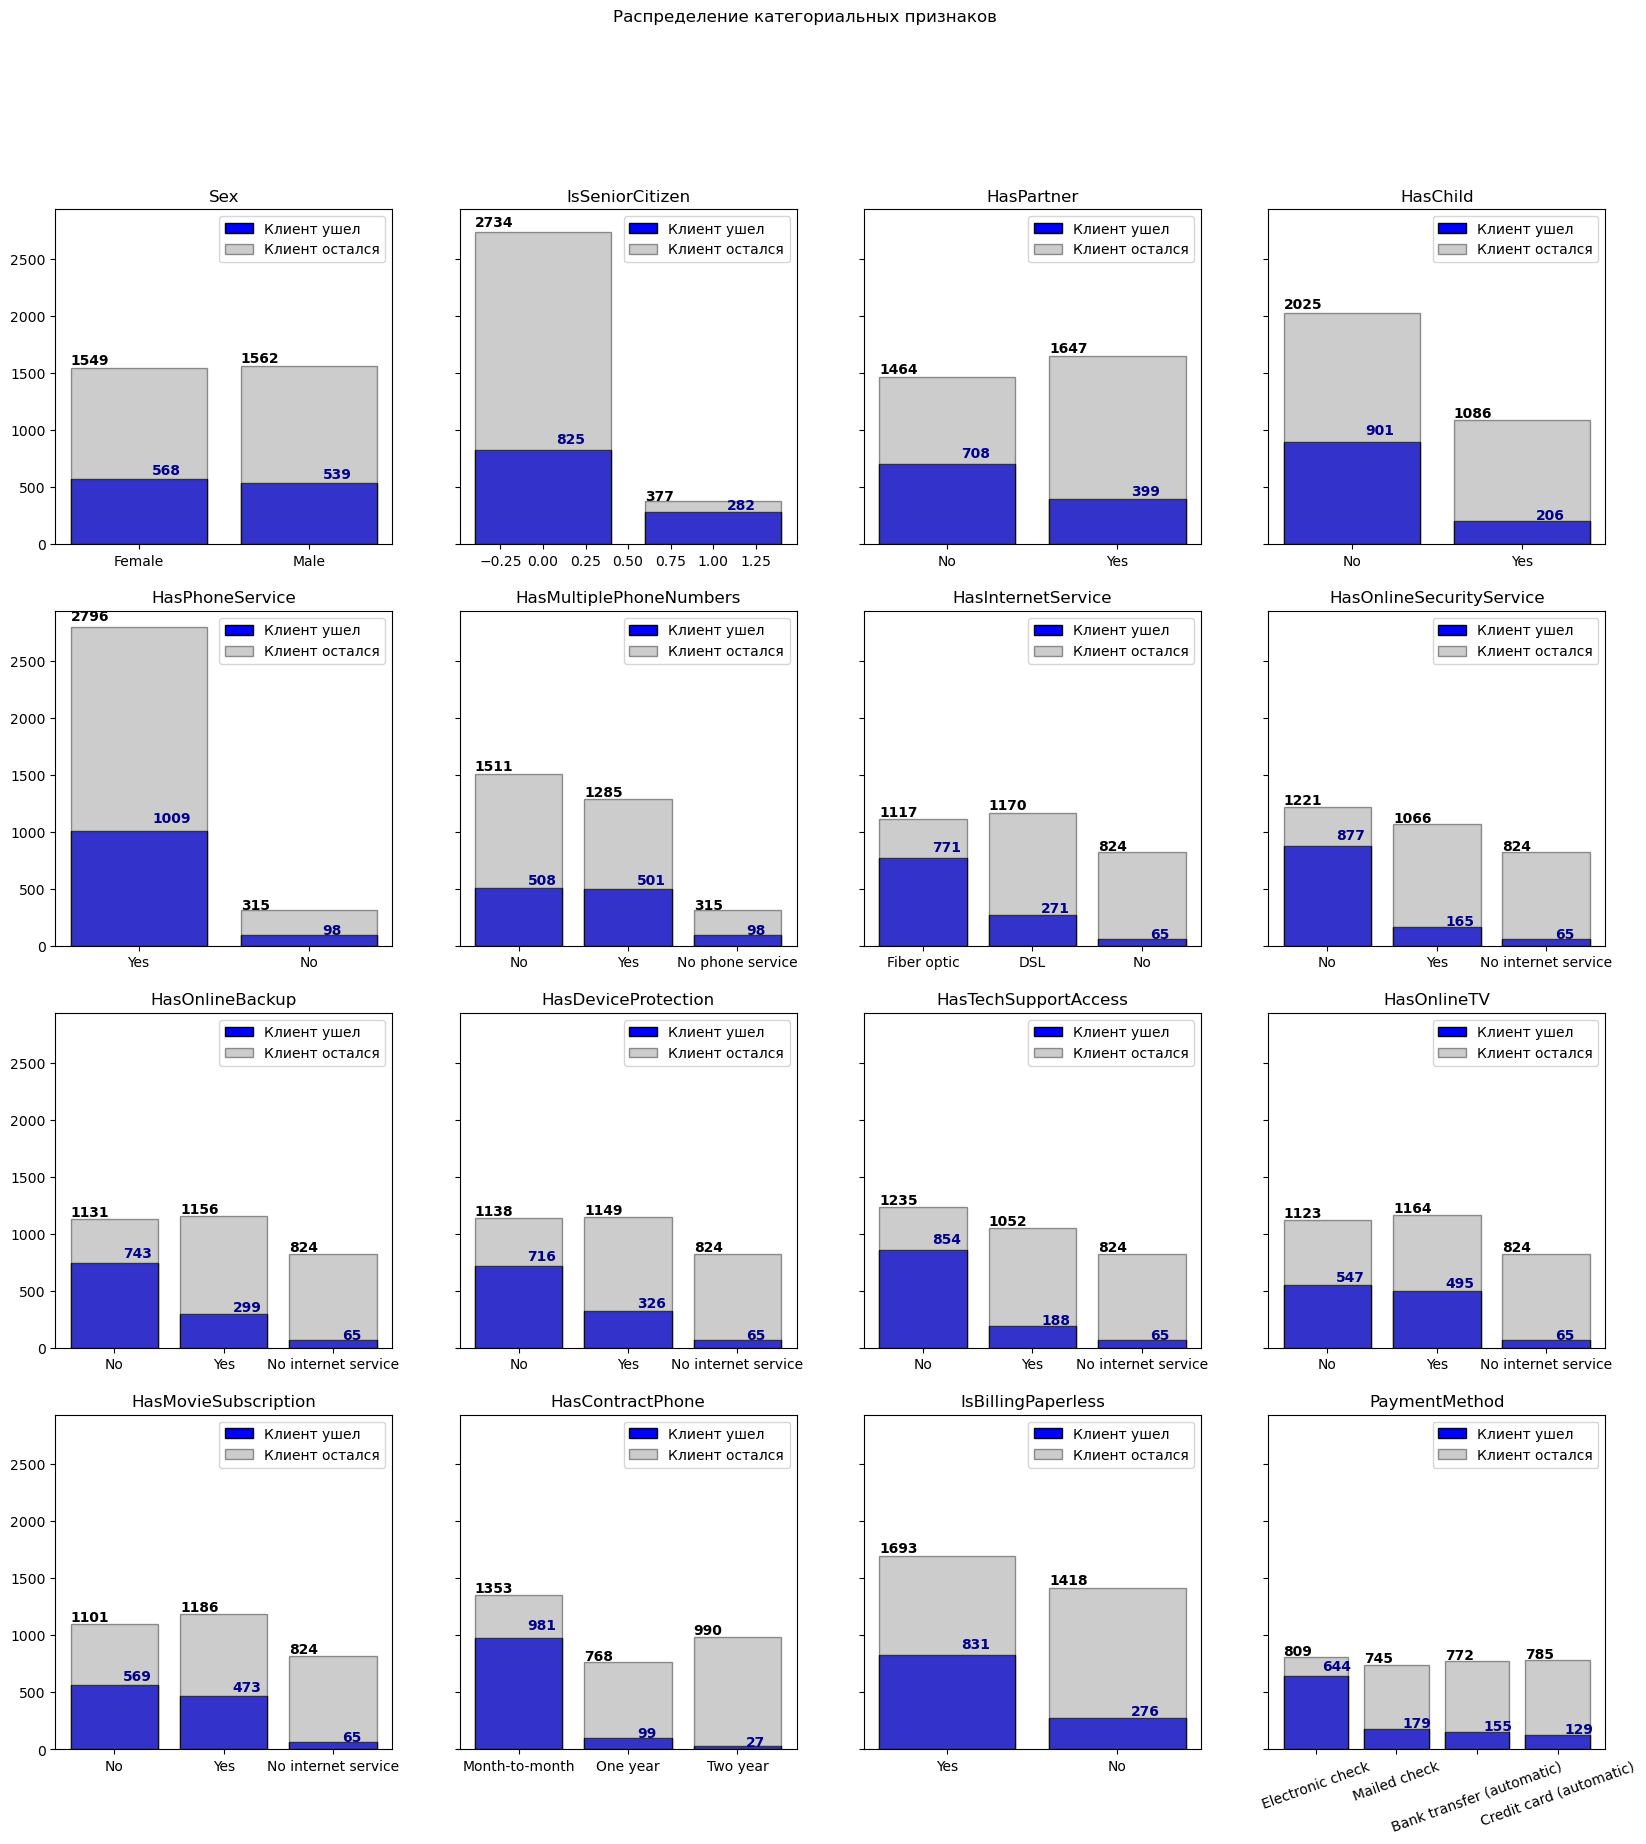

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)
ax = axes.ravel()
fig.suptitle('Распределение категориальных признаков')

for i, cat_col in enumerate(cat_cols):
  
  val_1 = train_1[cat_col].value_counts()
  val_0 = train_0[cat_col].value_counts()

  bars_1 = ax[i].bar(height=val_1,
                    x=val_1.index,
                    color='blue',
                    edgecolor='black',
                    label='Клиент ушел')
  
  bars_0 = ax[i].bar(height=val_0,
                    x=val_0.index,
                    color='grey',
                    edgecolor='black',
                    alpha=0.4,
                    label='Клиент остался')

  for bar in bars_1:
    ax[i].text(bar.get_x()+0.6*bar.get_width(),
               bar.get_height() * 1.07,
               bar.get_height(),
               color='darkblue',
               fontweight='bold')
    
  for bar in bars_0:
    ax[i].text(bar.get_x(),
               bar.get_height() * 1.02,
               bar.get_height(),
               color='black',
               fontweight='bold')
  
  ax[i].set_title(cat_col)
  ax[i].legend(loc='upper right')
  
  if cat_col=='PaymentMethod':
    plt.xticks(rotation=20)
plt.show()

Распределения категориальных признаков ничем не выделяются

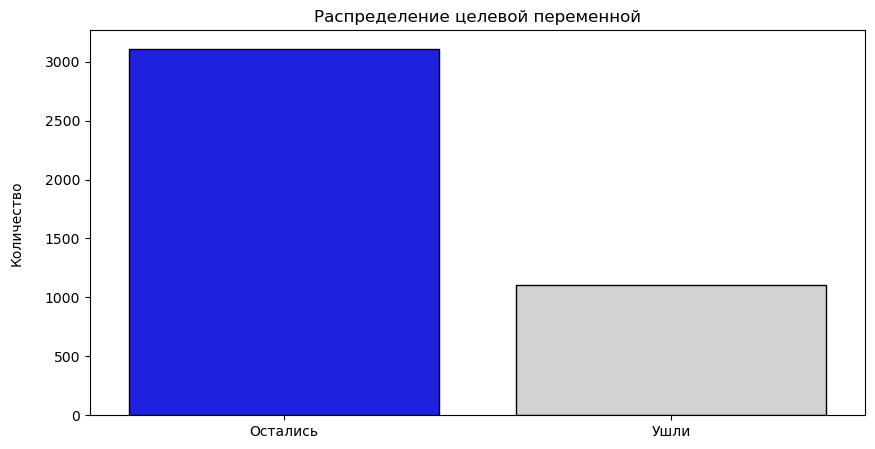

In [15]:
class_counts = y_train.value_counts().reset_index()
class_counts.columns = ['Churn', 'Count']

plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts['Churn'].map({0: 'Остались', 1: 'Ушли'}),
            y='Count', 
            data=class_counts, 
            hue='Churn',
            palette=['blue','lightgrey'],
            edgecolor='black',
            legend=False)
plt.title('Распределение целевой переменной')
plt.ylabel('Количество',labelpad=15)
plt.xlabel('')
plt.show()

Имеет место небольшой дизбаланс классов целевой переменной

## Логистическая регрессия


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

In [17]:
prep_pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

In [18]:
cls = make_pipeline(
    prep_pipeline,
    LogisticRegression(random_state=42, solver="saga", max_iter=1000)
    )

In [19]:
param_grid = {
    'logisticregression__penalty' : ['l1', 'l2', 'elasticnet', None],
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__class_weight': ['balanced', None],
    'logisticregression__l1_ratio': [0.1, 0.5, 0.7, 0.9]
    }

In [20]:
model = GridSearchCV(cls, param_grid, cv=5, verbose=0, scoring='roc_auc', refit=True, n_jobs=-1)

In [21]:
model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup...
                                                                          'PaymentMethod'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01,
                                                   0.001],
                         'logisticregression__class_weight': ['balanced', None],
                         'logisticregression__l1_ratio': [0.1, 0.5, 0.7, 0.9],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet', None]},
             scoring='roc_auc')

In [22]:
# Оптимальные гиперпараметры
model.best_params_

{'logisticregression__C': 100,
 'logisticregression__class_weight': None,
 'logisticregression__l1_ratio': 0.5,
 'logisticregression__penalty': 'elasticnet'}

In [23]:
# Оптимальные веса
model.best_estimator_.named_steps['logisticregression'].coef_

array([[-1.44348985e+00, -1.68527003e+00,  7.31223778e-01,
        -9.68704745e-02, -1.59009388e-01, -3.93939838e-01,
         0.00000000e+00, -1.33425631e-01, -1.22474513e-01,
        -8.27039220e-02, -1.73144062e-01, -4.71115926e-01,
         0.00000000e+00, -2.31990821e-01, -4.71115926e-01,
         3.19953521e-01, -9.42848177e-01,  1.08289596e+00,
        -5.23727831e-01,  2.09111674e-01, -5.23727831e-01,
        -6.90217672e-02, -2.24369221e-07, -5.23727831e-01,
         5.48335141e-02, -3.85382237e-02, -5.23727831e-01,
         1.89086269e-01,  2.82709819e-02, -5.23727831e-01,
         0.00000000e+00, -3.29403938e-01, -5.23727831e-01,
         4.70006375e-01, -2.59080146e-01, -5.23727831e-01,
         4.00882335e-01,  5.36220797e-01, -4.89478866e-02,
        -8.71637578e-01, -3.48308571e-01,  0.00000000e+00,
        -1.08173909e-01, -2.89657090e-01,  2.13208694e-01,
        -7.17043569e-02]])

In [24]:
# Результат на кросс-валидации с оптимальными гиперпараметрами
model.best_score_

0.8417563199327034

С помощью логистической регрессии на кросс-валидации удалось получить 0.8417563199327034

## Градиентный бустинг

In [25]:
from catboost import CatBoostClassifier

In [26]:
cb_model = CatBoostClassifier(
    loss_function='Logloss',
    cat_features=cat_cols,
    random_seed = 42,
    eval_metric='AUC',
    verbose=False,
    )

In [27]:
%%capture

grid_search_result = cb_model.grid_search({'max_depth': [3, 4],
                      'l2_leaf_reg': np.linspace(2, 15, num=7),
                      'n_estimators': [150, 200, 250],
                      'learning_rate': np.linspace(0.01, 0.2, 3)},
                      X=X_train,
                      y=y_train,
                      cv=3,
                      refit=True,
                      verbose=0)

In [28]:
# Лучшие гиперпараметры
grid_search_result['params']

{'depth': 3, 'learning_rate': 0.105, 'l2_leaf_reg': 2, 'iterations': 150}

In [29]:
best_cb_model = CatBoostClassifier(
    depth=4,
    learning_rate=0.105,
    l2_leaf_reg=2,
    n_estimators=200,
    loss_function='Logloss',
    cat_features=cat_cols,
    random_seed = 42,
    eval_metric='AUC',
    verbose=False,
)


In [30]:
best_cb_model.fit(X_train, y_train)

In [31]:
pred_train = best_cb_model.predict_proba(X_train)[:,1]

In [32]:
# Результат на кросс-валидации
roc_auc_score(y_train, pred_train)

0.8730652982089664

Результат для градиентного бустинга выше, посмотрим итоговое значение метрики на тестовых данных:

In [33]:
# Результат на тестовых данных
roc_auc_score(y_test, best_cb_model.predict_proba(X_test)[:,1])

0.8523776600187465

С помощью catboost на тестовых данных удалось получить 0.8523776600187465